# Import Packages

In [6]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import random
from sklearn.cluster import KMeans
from scipy.sparse import csc_matrix,csr_matrix
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

# MNIST Teacher Network

In [2]:
trainSetMNIST=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))
testSetMNIST=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))

In [ ]:
trainLoaderMNIST=DataLoader(dataset=trainSetMNIST,batch_size=4,shuffle=True)
testLoaderMNIST=DataLoader(dataset=testSetMNIST,batch_size=1,shuffle=True)

In [ ]:
example=iter(testLoaderMNIST)
image,label=example.next()
#print(image.shape,label.shape)
plt.imshow(image[0][0],cmap='gray')
tempExample=image
tempeLabel=label

In [3]:
trainLoaderMNIST=DataLoader(dataset=trainSetMNIST,batch_size=4,shuffle=True)
testLoaderMNIST=DataLoader(dataset=testSetMNIST,batch_size=10000,shuffle=False)

In [4]:
use_cuda=True
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,20,5,1)
        #self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(20,50,5,1)
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2=nn.Dropout2d(0.5)
        self.fc1=nn.Linear(800,500)
        self.fc2=nn.Linear(500,10)
        #self.fc3=nn.Linear(128,10)
    def forward(self,image):
        x=F.relu(self.conv1(image))
        x=F.max_pool2d(x,2,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2)
        x = x.view(x.size(0), -1)
        
        x=F.relu(self.fc1(x))
        
        x=self.fc2(x)
        return x
Teacher=ConvNet()
if use_cuda and torch.cuda.is_available():
    Teacher.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(Teacher.parameters(),lr=0.001,momentum=0.9)



In [5]:
def train():
    Teacher.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    for i,(image,labels) in enumerate(trainLoaderMNIST):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=Teacher(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return loss.item(),(correct/total)*100




In [6]:
def testMNIST(testLoaderMNIST):
    with torch.no_grad():
        Teacher.eval()
        correct=0
        total=0
        for i,(image,labels) in enumerate(testLoaderMNIST):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=Teacher(image)
            loss=criterion(prediction,labels)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
    return loss.item(),(correct/total)*100

In [7]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=train()
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.3021
epoch 1/10,batch 10000,loss=0.0833
epoch 1/10,batch 15000,loss=0.0630
epoch 2/10,batch 5000,loss=0.0436
epoch 2/10,batch 10000,loss=0.0428
epoch 2/10,batch 15000,loss=0.0388
epoch 3/10,batch 5000,loss=0.0280
epoch 3/10,batch 10000,loss=0.0292
epoch 3/10,batch 15000,loss=0.0289
epoch 4/10,batch 5000,loss=0.0202
epoch 4/10,batch 10000,loss=0.0200
epoch 4/10,batch 15000,loss=0.0206
epoch 5/10,batch 5000,loss=0.0137
epoch 5/10,batch 10000,loss=0.0161
epoch 5/10,batch 15000,loss=0.0160
epoch 6/10,batch 5000,loss=0.0097
epoch 6/10,batch 10000,loss=0.0136
epoch 6/10,batch 15000,loss=0.0090
epoch 7/10,batch 5000,loss=0.0082
epoch 7/10,batch 10000,loss=0.0078
epoch 7/10,batch 15000,loss=0.0085
epoch 8/10,batch 5000,loss=0.0047
epoch 8/10,batch 10000,loss=0.0046
epoch 8/10,batch 15000,loss=0.0092
epoch 9/10,batch 5000,loss=0.0038
epoch 9/10,batch 10000,loss=0.0041
epoch 9/10,batch 15000,loss=0.0055
epoch 10/10,batch 5000,loss=0.0045
epoch 10/10,batch 10000,loss=

In [7]:
##Duplicate
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=train()
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.2996
epoch 1/10,batch 10000,loss=0.0825
epoch 1/10,batch 15000,loss=0.0635
epoch 2/10,batch 5000,loss=0.0446
epoch 2/10,batch 10000,loss=0.0388
epoch 2/10,batch 15000,loss=0.0408
epoch 3/10,batch 5000,loss=0.0276
epoch 3/10,batch 10000,loss=0.0271
epoch 3/10,batch 15000,loss=0.0289
epoch 4/10,batch 5000,loss=0.0208
epoch 4/10,batch 10000,loss=0.0213
epoch 4/10,batch 15000,loss=0.0198
epoch 5/10,batch 5000,loss=0.0134
epoch 5/10,batch 10000,loss=0.0140
epoch 5/10,batch 15000,loss=0.0167
epoch 6/10,batch 5000,loss=0.0121
epoch 6/10,batch 10000,loss=0.0123
epoch 6/10,batch 15000,loss=0.0103
epoch 7/10,batch 5000,loss=0.0101
epoch 7/10,batch 10000,loss=0.0104
epoch 7/10,batch 15000,loss=0.0072
epoch 8/10,batch 5000,loss=0.0046
epoch 8/10,batch 10000,loss=0.0059
epoch 8/10,batch 15000,loss=0.0083
epoch 9/10,batch 5000,loss=0.0040
epoch 9/10,batch 10000,loss=0.0034
epoch 9/10,batch 15000,loss=0.0053
epoch 10/10,batch 5000,loss=0.0022
epoch 10/10,batch 10000,loss=

In [7]:
##Duplicate again
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=train()
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.3034
epoch 1/10,batch 10000,loss=0.0836
epoch 1/10,batch 15000,loss=0.0633
epoch 2/10,batch 5000,loss=0.0445
epoch 2/10,batch 10000,loss=0.0425
epoch 2/10,batch 15000,loss=0.0392
epoch 3/10,batch 5000,loss=0.0277
epoch 3/10,batch 10000,loss=0.0312
epoch 3/10,batch 15000,loss=0.0264
epoch 4/10,batch 5000,loss=0.0227
epoch 4/10,batch 10000,loss=0.0194
epoch 4/10,batch 15000,loss=0.0221
epoch 5/10,batch 5000,loss=0.0148
epoch 5/10,batch 10000,loss=0.0149
epoch 5/10,batch 15000,loss=0.0179
epoch 6/10,batch 5000,loss=0.0107
epoch 6/10,batch 10000,loss=0.0096
epoch 6/10,batch 15000,loss=0.0150
epoch 7/10,batch 5000,loss=0.0074
epoch 7/10,batch 10000,loss=0.0069
epoch 7/10,batch 15000,loss=0.0108
epoch 8/10,batch 5000,loss=0.0066
epoch 8/10,batch 10000,loss=0.0075
epoch 8/10,batch 15000,loss=0.0098
epoch 9/10,batch 5000,loss=0.0045
epoch 9/10,batch 10000,loss=0.0066
epoch 9/10,batch 15000,loss=0.0056
epoch 10/10,batch 5000,loss=0.0043
epoch 10/10,batch 10000,loss=

In [ ]:
temp=[1,7,10,15,20,30]
def softmaxFunction(weight):
    weight=weight.cpu()
    return np.exp(weight)/np.exp(weight).sum()
values=list()
for value in temp:
    with torch.no_grad():
        if use_cuda and torch.cuda.is_available():
            tempExample=tempExample.cuda()
            tempeLabel=tempeLabel.cuda()
        print(tempExample.shape)
        prediction=Teacher(tempExample)
        
        softmaxOutput=softmaxFunction(prediction/value)
        values.append(softmaxOutput)

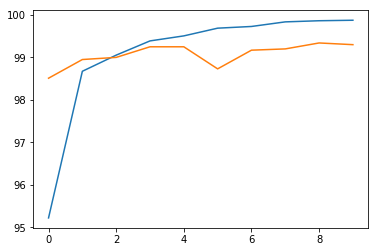

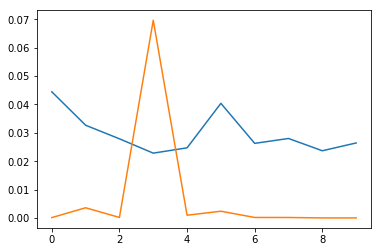

In [8]:
plt.figure()
plt.plot(trainaccuracy)
plt.plot(testaccuracy)
plt.figure()
plt.plot(testloss)
plt.plot(trainloss)

In [8]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=99.875
Test accuracy=99.25


In [8]:
##Duplicate
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=99.89833333333334
Test accuracy=99.27


In [8]:
##Duplicate again again
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=99.87666666666667
Test accuracy=99.17


In [9]:
pytorch_total_params = sum(p.numel() for p in Teacher.parameters())
print(f'Total number of parameters of Teacher model is {pytorch_total_params}')
print(f'Total space occupied by the model is {pytorch_total_params*4} bytes')

Total number of parameters of Teacher model is 431080
Total space occupied by the model is 1724320 bytes


# MNIST Student Network

In [10]:
temp=7
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,32)
        #self.dropout1 = nn.Dropout2d(0.25)
        self.fc2=nn.Linear(32,10)
        #self.fc3=nn.Linear(800,10)
        #self.fc1.weight_orig=self.fc1.weight
        #del self.fc1.weight
        #self.fc2.weight_orig=self.fc2.weight
        #del self.fc2.weight
        #self.fc3.weight_orig=self.fc3.weight
        #del self.fc3.weight
    def forward(self,data):
        x=data.view(-1,28*28)
        #self.fc1.weight=getQuantizedWeights(self.fc1.weight_orig)
        #print(self.fc1.weight)
        x=F.relu(self.fc1(x))
        #x=self.dropout1(x)
        #self.fc2.weight=getQuantizedWeights(self.fc2.weight_orig)
        #print(self.fc2.weight)
        #x=F.relu(self.fc2(x))
        #self.fc3.weight=getQuantizedWeights(self.fc3.weight_orig)
        x=self.fc2(x)
        return x
def knowledgedistillationloss(outputs,labels,weightTeacher,alpha):
    return nn.KLDivLoss()(F.log_softmax(outputs/temp,dim=1),F.softmax(weightTeacher/temp,dim=1))+alpha*F.cross_entropy(outputs,labels)
'''def knowledgedistillationloss(studentLogits,teacherLogits,minibatchsize):
    return (1/2*minibatchsize)*(studentLogits-teacherLogits)'''
modelStudent=Student()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStudent.cuda()
optimizer=torch.optim.SGD(modelStudent.parameters(),lr=0.001,momentum=0.9)
def trainStudent():
    modelStudent.train()
    Teacher.eval()
    runningloss=0.0
    correct=0
    total=0
    totalLoss=0.0
    for i,(data,labels) in enumerate(trainLoaderMNIST):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=modelStudent(data)
        weightTeacher=Teacher(data)
        weightTeacher=weightTeacher.detach()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        #print(weightTeacher.shape,predicted.shape,labels.shape)
        loss=knowledgedistillationloss(predicted,labels,weightTeacher,0.1)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        #modelStudent.fc1.weight.grad_orig=modelStudent.fc1.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc2.weight.grad_orig=modelStudent.fc2.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc3.weight.grad_orig=modelStudent.fc3.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc1.weight.grad=getQuantizedWeights(modelStudent.fc1.weight.grad_orig)
        #modelStudent.fc2.weight.grad=getQuantizedWeights(modelStudent.fc2.weight.grad_orig)
        #modelStudent.fc3.weight.grad=getQuantizedWeights(modelStudent.fc3.weight.grad_orig)
        optimizer.step()
        runningloss+=loss.item()
        totalLoss=loss.item()
            #print(loss.item())
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return totalLoss/len(trainLoaderMNIST),(correct/total)*100
                

# MNIST Student Network second architecture

In [13]:
##Duplicate
temp=7
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,256)
        #self.dropout1 = nn.Dropout2d(0.25)
        self.fc2=nn.Linear(256,10)
        #self.fc3=nn.Linear(800,10)
        #self.fc1.weight_orig=self.fc1.weight
        #del self.fc1.weight
        #self.fc2.weight_orig=self.fc2.weight
        #del self.fc2.weight
        #self.fc3.weight_orig=self.fc3.weight
        #del self.fc3.weight
    def forward(self,data):
        x=data.view(-1,28*28)
        #self.fc1.weight=getQuantizedWeights(self.fc1.weight_orig)
        #print(self.fc1.weight)
        x=F.relu(self.fc1(x))
        #x=self.dropout1(x)
        #self.fc2.weight=getQuantizedWeights(self.fc2.weight_orig)
        #print(self.fc2.weight)
        #x=F.relu(self.fc2(x))
        #self.fc3.weight=getQuantizedWeights(self.fc3.weight_orig)
        x=self.fc2(x)
        return x
def knowledgedistillationloss(outputs,labels,weightTeacher,alpha):
    return (temp**2)*nn.KLDivLoss()(F.log_softmax(outputs/temp,dim=1),F.softmax(weightTeacher/temp,dim=1))+alpha*F.cross_entropy(outputs,labels)
'''def knowledgedistillationloss(studentLogits,teacherLogits,minibatchsize):
    return (1/2*minibatchsize)*(studentLogits-teacherLogits)'''
modelStudent=Student()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStudent.cuda()
optimizer=torch.optim.SGD(modelStudent.parameters(),lr=0.001,momentum=0.9)
def trainStudent():
    modelStudent.train()
    Teacher.eval()
    runningloss=0.0
    correct=0
    total=0
    totalLoss=0.0
    for i,(data,labels) in enumerate(trainLoaderMNIST):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=modelStudent(data)
        weightTeacher=Teacher(data)
        weightTeacher=weightTeacher.detach()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        #print(weightTeacher.shape,predicted.shape,labels.shape)
        loss=knowledgedistillationloss(predicted,labels,weightTeacher,0.1)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        #modelStudent.fc1.weight.grad_orig=modelStudent.fc1.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc2.weight.grad_orig=modelStudent.fc2.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc3.weight.grad_orig=modelStudent.fc3.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc1.weight.grad=getQuantizedWeights(modelStudent.fc1.weight.grad_orig)
        #modelStudent.fc2.weight.grad=getQuantizedWeights(modelStudent.fc2.weight.grad_orig)
        #modelStudent.fc3.weight.grad=getQuantizedWeights(modelStudent.fc3.weight.grad_orig)
        optimizer.step()
        runningloss+=loss.item()
        totalLoss=loss.item()
            #print(loss.item())
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return totalLoss/len(trainLoaderMNIST),(correct/total)*100
                

In [14]:
def testStudent(testLoader):
    modelStudent.eval()
    Teacher.eval()
    with torch.no_grad():
        correct=0.0
        total=0.0
        totalLoss=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=Teacher(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
            totalLoss+=loss.item()
    return totalLoss/len(testLoader),(correct/total)*100

In [12]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=20
for epoch in range(epochs):
    loss,accuracy=trainStudent()
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/20,batch 5000,loss=0.1985
epoch 1/20,batch 10000,loss=0.1115
epoch 1/20,batch 15000,loss=0.0943
epoch 2/20,batch 5000,loss=0.0862
epoch 2/20,batch 10000,loss=0.0807
epoch 2/20,batch 15000,loss=0.0787
epoch 3/20,batch 5000,loss=0.0755
epoch 3/20,batch 10000,loss=0.0738
epoch 3/20,batch 15000,loss=0.0716
epoch 4/20,batch 5000,loss=0.0691
epoch 4/20,batch 10000,loss=0.0687
epoch 4/20,batch 15000,loss=0.0679
epoch 5/20,batch 5000,loss=0.0644
epoch 5/20,batch 10000,loss=0.0653
epoch 5/20,batch 15000,loss=0.0628
epoch 6/20,batch 5000,loss=0.0613
epoch 6/20,batch 10000,loss=0.0619
epoch 6/20,batch 15000,loss=0.0569
epoch 7/20,batch 5000,loss=0.0574
epoch 7/20,batch 10000,loss=0.0557
epoch 7/20,batch 15000,loss=0.0548
epoch 8/20,batch 5000,loss=0.0533
epoch 8/20,batch 10000,loss=0.0518
epoch 8/20,batch 15000,loss=0.0514
epoch 9/20,batch 5000,loss=0.0495
epoch 9/20,batch 10000,loss=0.0484
epoch 9/20,batch 15000,loss=0.0485
epoch 10/20,batch 5000,loss=0.0465
epoch 10/20,batch 10000,loss=

In [11]:
##MNIST Student 2nd Architecture
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=20
for epoch in range(epochs):
    loss,accuracy=trainStudent()
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/20,batch 5000,loss=0.1921
epoch 1/20,batch 10000,loss=0.1083
epoch 1/20,batch 15000,loss=0.0899
epoch 2/20,batch 5000,loss=0.0827
epoch 2/20,batch 10000,loss=0.0779
epoch 2/20,batch 15000,loss=0.0755
epoch 3/20,batch 5000,loss=0.0718
epoch 3/20,batch 10000,loss=0.0688
epoch 3/20,batch 15000,loss=0.0684
epoch 4/20,batch 5000,loss=0.0654
epoch 4/20,batch 10000,loss=0.0624
epoch 4/20,batch 15000,loss=0.0599
epoch 5/20,batch 5000,loss=0.0575
epoch 5/20,batch 10000,loss=0.0564
epoch 5/20,batch 15000,loss=0.0552
epoch 6/20,batch 5000,loss=0.0519
epoch 6/20,batch 10000,loss=0.0504
epoch 6/20,batch 15000,loss=0.0492
epoch 7/20,batch 5000,loss=0.0465
epoch 7/20,batch 10000,loss=0.0464
epoch 7/20,batch 15000,loss=0.0433
epoch 8/20,batch 5000,loss=0.0424
epoch 8/20,batch 10000,loss=0.0402
epoch 8/20,batch 15000,loss=0.0398
epoch 9/20,batch 5000,loss=0.0387
epoch 9/20,batch 10000,loss=0.0364
epoch 9/20,batch 15000,loss=0.0358
epoch 10/20,batch 5000,loss=0.0355
epoch 10/20,batch 10000,loss=

In [15]:
##Run for 30 epochs 2nd architecture
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=30
for epoch in range(epochs):
    loss,accuracy=trainStudent()
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/30,batch 5000,loss=1.6734
epoch 1/30,batch 10000,loss=0.7434
epoch 1/30,batch 15000,loss=0.5307
epoch 2/30,batch 5000,loss=0.4120
epoch 2/30,batch 10000,loss=0.3546
epoch 2/30,batch 15000,loss=0.3103
epoch 3/30,batch 5000,loss=0.2696
epoch 3/30,batch 10000,loss=0.2456
epoch 3/30,batch 15000,loss=0.2313
epoch 4/30,batch 5000,loss=0.2058
epoch 4/30,batch 10000,loss=0.2045
epoch 4/30,batch 15000,loss=0.1865
epoch 5/30,batch 5000,loss=0.1723
epoch 5/30,batch 10000,loss=0.1714
epoch 5/30,batch 15000,loss=0.1678
epoch 6/30,batch 5000,loss=0.1546
epoch 6/30,batch 10000,loss=0.1494
epoch 6/30,batch 15000,loss=0.1496
epoch 7/30,batch 5000,loss=0.1365
epoch 7/30,batch 10000,loss=0.1396
epoch 7/30,batch 15000,loss=0.1357
epoch 8/30,batch 5000,loss=0.1280
epoch 8/30,batch 10000,loss=0.1276
epoch 8/30,batch 15000,loss=0.1225
epoch 9/30,batch 5000,loss=0.1175
epoch 9/30,batch 10000,loss=0.1161
epoch 9/30,batch 15000,loss=0.1175
epoch 10/30,batch 5000,loss=0.1095
epoch 10/30,batch 10000,loss=

In [45]:
##Duplicate again
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=20
for epoch in range(epochs):
    loss,accuracy=trainStudent()
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/20,batch 5000,loss=0.1913
epoch 1/20,batch 10000,loss=0.1088
epoch 1/20,batch 15000,loss=0.0914
epoch 2/20,batch 5000,loss=0.0832
epoch 2/20,batch 10000,loss=0.0801
epoch 2/20,batch 15000,loss=0.0749
epoch 3/20,batch 5000,loss=0.0736
epoch 3/20,batch 10000,loss=0.0699
epoch 3/20,batch 15000,loss=0.0681
epoch 4/20,batch 5000,loss=0.0653
epoch 4/20,batch 10000,loss=0.0654
epoch 4/20,batch 15000,loss=0.0611
epoch 5/20,batch 5000,loss=0.0596
epoch 5/20,batch 10000,loss=0.0560
epoch 5/20,batch 15000,loss=0.0574
epoch 6/20,batch 5000,loss=0.0524
epoch 6/20,batch 10000,loss=0.0531
epoch 6/20,batch 15000,loss=0.0497
epoch 7/20,batch 5000,loss=0.0487
epoch 7/20,batch 10000,loss=0.0458
epoch 7/20,batch 15000,loss=0.0455
epoch 8/20,batch 5000,loss=0.0441
epoch 8/20,batch 10000,loss=0.0414
epoch 8/20,batch 15000,loss=0.0407
epoch 9/20,batch 5000,loss=0.0381
epoch 9/20,batch 10000,loss=0.0383
epoch 9/20,batch 15000,loss=0.0374
epoch 10/20,batch 5000,loss=0.0359
epoch 10/20,batch 10000,loss=

In [13]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=96.19
Test accuracy=95.62


In [12]:
##MNIST Student 2nd Architecture
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=97.77
Test accuracy=97.25


In [46]:
##Duplicate again
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=97.735
Test accuracy=97.08


In [16]:
##Duplicate again again(30 epochs)
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=99.58666666666667
Test accuracy=98.54


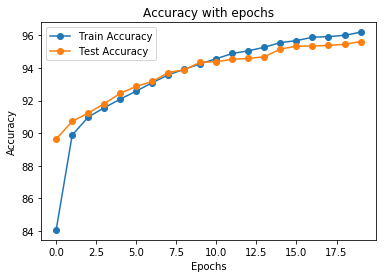

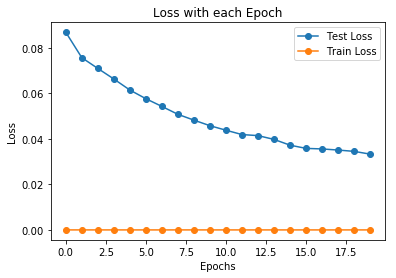

In [14]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

In [15]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'The total number of Parameteres are {pytorch_total_params}')
print(f'Total size of the file is {pytorch_total_params*4} bytes')

The total number of Parameteres are 25450
Total size of the file is 101800 bytes


In [13]:
##MNIST student 2nd Architecture
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'The total number of Parameteres are {pytorch_total_params}')
print(f'Total size of the file is {pytorch_total_params*4} bytes')

The total number of Parameteres are 203530
Total size of the file is 814120 bytes


# Quantization of student architecture

In [17]:
##If running for 1st architecture choose the. weight clusters as 10 and bias clusters as 4,if running for the second architecture
##choose weight clusters as 128 and bias cluster for 1st layer as 10 and second layer as 4
def getQuantizedWeights(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0]*weightCopy.shape[1],-1)).reshape(weightCopy.shape[0],weightCopy.shape[1])
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight[i][j]=torch.from_numpy(kmeans.cluster_centers_[labels[i][j]])
        #print(weight)
    return weight
modelStudent.fc1.weight_orig=modelStudent.fc1.weight
#print(modelStudent.fc1.weight_orig)
#del modelStudent.fc1.weight
modelStudent.fc2.weight_orig=modelStudent.fc2.weight
#del modelStudent.fc2.weight
#modelStudent.fc3.weight_orig=modelStudent.fc3.weight
#del modelStudent.fc3.weight
modelStudent.fc1.weight=getQuantizedWeights(modelStudent.fc1.weight_orig,128)
modelStudent.fc2.weight=getQuantizedWeights(modelStudent.fc2.weight_orig,128)
#modelStudent.fc3.weight=getQuantizedWeights(modelStudent.fc3.weight_orig,10)

In [18]:
def getQuantizedWeightsBias(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        #print(weightCopy.view(weightCopy.shape[0],-1).shape)
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0],-1))
        #print(labels)
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            weight[i]=torch.from_numpy(kmeans.cluster_centers_[labels[i]])
    return weight
modelStudent.fc1.bias_orig=modelStudent.fc1.bias
#print(modelStudent.fc1.bias_orig)
#del modelStudent.fc1.bias
modelStudent.fc2.bias_orig=modelStudent.fc2.bias
#del modelStudent.fc2.weight
#modelStudent.fc3.bias_orig=modelStudent.fc3.bias
#del modelStudent.fc3.bias
#print(getQuantizedWeightsBias(modelStudent.fc1.bias_orig,4))
modelStudent.fc1.bias=getQuantizedWeightsBias(modelStudent.fc1.bias_orig,10)
modelStudent.fc2.bias=getQuantizedWeightsBias(modelStudent.fc2.bias_orig,4)
#modelStudent.fc3.bias=getQuantizedWeightsBias(modelStudent.fc3.bias_orig,4)
#print(modelStudent.fc1.bias)

In [18]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=Teacher(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=9491.0,accuracy=94.91000000000001


In [16]:
##MNIST Student second architecture
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=Teacher(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=9665.0,accuracy=96.65


In [49]:
##DUPLICATE AGAIN
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=Teacher(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=9708.0,accuracy=97.08


In [19]:
##DUPLICATE AGAIN(30 epochs with temp)
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=Teacher(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=9851.0,accuracy=98.50999999999999


In [19]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'The total number of Parameters are {pytorch_total_params}')
additionalParameters=(32*10*2)+(32*4*2)
print(f'Total size of the file is {(pytorch_total_params/2)+(additionalParameters/8)} bytes')

The total number of Parameters are 25450
Total size of the file is 12837.0 bytes


In [17]:
##MNIST student second architecture
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'The total number of Parameters are {pytorch_total_params}')
additionalParameters=(32*10*2)+(32*4*2)
print(f'Total size of the file is {(pytorch_total_params/2)+(additionalParameters/8)} bytes')

The total number of Parameters are 203530
Total size of the file is 101877.0 bytes


In [50]:
##Duplicate
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'The total number of Parameters are {pytorch_total_params}')
additionalParameters=(32*128*2)+(32*2)+(32*3)
print(f'Total size of the file is {((pytorch_total_params*7)/8)+(additionalParameters/8)} bytes')

The total number of Parameters are 203530
Total size of the file is 179168.75 bytes


# Standalone Student Architecture

In [4]:
class StandaloneStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,32)
        
        self.fc3=nn.Linear(32,10)
       
    def forward(self,data):
        x=data.view(-1,28*28)

        x=F.relu(self.fc1(x))
        
        x=self.fc3(x)
        return x
modelStandaloneStudent=StandaloneStudent()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStandaloneStudent.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(modelStandaloneStudent.parameters(),lr=0.001,momentum=0.9)
def train(trainLoaderMNIST):
    modelStandaloneStudent.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    runninglosstotal=0.0
    for i,(image,labels) in enumerate(trainLoaderMNIST):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=modelStandaloneStudent(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        runninglosstotal+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return runninglosstotal/len(trainLoaderMNIST),(correct/total)*100

In [18]:
##Standalone student model for 2nd architecture,try reducing the learning rate to 0.01 and see the performance deterioration
##Thsis performance deterioration would not be seen in case of Knoweledge Distillation
class StandaloneStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,256)
        
        self.fc3=nn.Linear(256,10)
       
    def forward(self,data):
        x=data.view(-1,28*28)

        x=F.relu(self.fc1(x))
        
        x=self.fc3(x)
        return x
modelStandaloneStudent=StandaloneStudent()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStandaloneStudent.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(modelStandaloneStudent.parameters(),lr=0.001,momentum=0.9)
def train(trainLoaderMNIST):
    modelStandaloneStudent.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    runninglosstotal=0.0
    for i,(image,labels) in enumerate(trainLoaderMNIST):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=modelStandaloneStudent(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        runninglosstotal+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return runninglosstotal/len(trainLoaderMNIST),(correct/total)*100

In [19]:
def testMNIST(testLoaderMNIST):
    with torch.no_grad():
        modelStandaloneStudent.eval()
        correct=0
        total=0
        runningLoss=0
        for i,(image,labels) in enumerate(testLoaderMNIST):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=modelStandaloneStudent(image)
            loss=criterion(prediction,labels)
            runningLoss+=loss.item()
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
    return runningLoss/len(testLoaderMNIST),(correct/total)*100

In [6]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=4
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/4,batch 5000,loss=0.5135
epoch 1/4,batch 10000,loss=0.3303
epoch 1/4,batch 15000,loss=0.2693
epoch 2/4,batch 5000,loss=0.2317
epoch 2/4,batch 10000,loss=0.2302
epoch 2/4,batch 15000,loss=0.2063
epoch 3/4,batch 5000,loss=0.1919
epoch 3/4,batch 10000,loss=0.1833
epoch 3/4,batch 15000,loss=0.1758
epoch 4/4,batch 5000,loss=0.1632
epoch 4/4,batch 10000,loss=0.1653
epoch 4/4,batch 15000,loss=0.1657


In [20]:
##Mnist student second architecture
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=4
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/4,batch 5000,loss=0.4621
epoch 1/4,batch 10000,loss=0.2611
epoch 1/4,batch 15000,loss=0.1954
epoch 2/4,batch 5000,loss=0.1557
epoch 2/4,batch 10000,loss=0.1408
epoch 2/4,batch 15000,loss=0.1355
epoch 3/4,batch 5000,loss=0.1093
epoch 3/4,batch 10000,loss=0.1076
epoch 3/4,batch 15000,loss=0.0998
epoch 4/4,batch 5000,loss=0.0872
epoch 4/4,batch 10000,loss=0.0799
epoch 4/4,batch 15000,loss=0.0864


In [7]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=94.92666666666668
Test accuracy=95.25


In [21]:
##Mnist student second architecture
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=97.355
Test accuracy=96.98


# Fashion MNIST Dataset 

In [20]:
trainSetFashionMNIST=torchvision.datasets.FashionMNIST(root='./data',train=True,transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))]),download=True)
testSetFashionMNIST=torchvision.datasets.FashionMNIST(root='./data',train=False,transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))]),download=True)

In [21]:
trainLoaderFashionMNIST=DataLoader(dataset=trainSetFashionMNIST,batch_size=4,shuffle=True)
testLoaderFashionMNIST=DataLoader(dataset=testSetFashionMNIST,batch_size=10000,shuffle=False)

# Fashion MNIST Teacher network

In [22]:
use_cuda=True
'''class ConvNetFashion(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,6,5)
        #self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(256,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,image):
        x=F.relu(self.conv1(image))
        x = F.max_pool2d(x, kernel_size=2)
        x=  F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x'''
class ConvNetFashion(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x
        return output
modelFashion=ConvNetFashion()
if use_cuda and torch.cuda.is_available():
    modelFashion.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(modelFashion.parameters(),lr=0.0001)

In [23]:
def trainFashionMNIST(trainLoader):
    modelFashion.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    totalLoss=0.0
    for i,(image,labels) in enumerate(trainLoader):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=modelFashion(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        totalLoss+=loss.item()
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return totalLoss/len(trainLoader),(correct/total)*100

In [24]:
def testFashionMNIST(testLoader):
    with torch.no_grad():
        modelFashion.eval()
        correct=0
        total=0
        runningLoss=0.0
        for i,(image,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=modelFashion(image)
            loss=criterion(prediction,labels)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
            runningLoss+=loss.item()
    return runningLoss/len(testLoader),(correct/total)*100

In [7]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainFashionMNIST(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testFashionMNIST(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.6530
epoch 1/10,batch 10000,loss=0.4621
epoch 1/10,batch 15000,loss=0.4063
epoch 2/10,batch 5000,loss=0.3662
epoch 2/10,batch 10000,loss=0.3496
epoch 2/10,batch 15000,loss=0.3438
epoch 3/10,batch 5000,loss=0.3053
epoch 3/10,batch 10000,loss=0.3098
epoch 3/10,batch 15000,loss=0.2999
epoch 4/10,batch 5000,loss=0.2770
epoch 4/10,batch 10000,loss=0.2665
epoch 4/10,batch 15000,loss=0.2708
epoch 5/10,batch 5000,loss=0.2470
epoch 5/10,batch 10000,loss=0.2462
epoch 5/10,batch 15000,loss=0.2488
epoch 6/10,batch 5000,loss=0.2303
epoch 6/10,batch 10000,loss=0.2285
epoch 6/10,batch 15000,loss=0.2327
epoch 7/10,batch 5000,loss=0.2171
epoch 7/10,batch 10000,loss=0.2100
epoch 7/10,batch 15000,loss=0.2104
epoch 8/10,batch 5000,loss=0.1946
epoch 8/10,batch 10000,loss=0.1923
epoch 8/10,batch 15000,loss=0.2044
epoch 9/10,batch 5000,loss=0.1806
epoch 9/10,batch 10000,loss=0.1820
epoch 9/10,batch 15000,loss=0.1906
epoch 10/10,batch 5000,loss=0.1713
epoch 10/10,batch 10000,loss=

In [27]:
##Duplicate
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainFashionMNIST(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testFashionMNIST(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.6690
epoch 1/10,batch 10000,loss=0.4494
epoch 1/10,batch 15000,loss=0.4087
epoch 2/10,batch 5000,loss=0.3590
epoch 2/10,batch 10000,loss=0.3451
epoch 2/10,batch 15000,loss=0.3318
epoch 3/10,batch 5000,loss=0.3087
epoch 3/10,batch 10000,loss=0.2926
epoch 3/10,batch 15000,loss=0.2907
epoch 4/10,batch 5000,loss=0.2638
epoch 4/10,batch 10000,loss=0.2627
epoch 4/10,batch 15000,loss=0.2698
epoch 5/10,batch 5000,loss=0.2448
epoch 5/10,batch 10000,loss=0.2376
epoch 5/10,batch 15000,loss=0.2420
epoch 6/10,batch 5000,loss=0.2191
epoch 6/10,batch 10000,loss=0.2210
epoch 6/10,batch 15000,loss=0.2218
epoch 7/10,batch 5000,loss=0.2064
epoch 7/10,batch 10000,loss=0.2053
epoch 7/10,batch 15000,loss=0.2076
epoch 8/10,batch 5000,loss=0.1922
epoch 8/10,batch 10000,loss=0.1901
epoch 8/10,batch 15000,loss=0.1867
epoch 9/10,batch 5000,loss=0.1781
epoch 9/10,batch 10000,loss=0.1788
epoch 9/10,batch 15000,loss=0.1784
epoch 10/10,batch 5000,loss=0.1642
epoch 10/10,batch 10000,loss=

In [25]:
##Duplicate again again
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainFashionMNIST(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testFashionMNIST(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.6673
epoch 1/10,batch 10000,loss=0.4614
epoch 1/10,batch 15000,loss=0.4026
epoch 2/10,batch 5000,loss=0.3647
epoch 2/10,batch 10000,loss=0.3474
epoch 2/10,batch 15000,loss=0.3412
epoch 3/10,batch 5000,loss=0.2959
epoch 3/10,batch 10000,loss=0.3002
epoch 3/10,batch 15000,loss=0.2964
epoch 4/10,batch 5000,loss=0.2652
epoch 4/10,batch 10000,loss=0.2653
epoch 4/10,batch 15000,loss=0.2648
epoch 5/10,batch 5000,loss=0.2384
epoch 5/10,batch 10000,loss=0.2393
epoch 5/10,batch 15000,loss=0.2407
epoch 6/10,batch 5000,loss=0.2179
epoch 6/10,batch 10000,loss=0.2244
epoch 6/10,batch 15000,loss=0.2221
epoch 7/10,batch 5000,loss=0.2019
epoch 7/10,batch 10000,loss=0.2033
epoch 7/10,batch 15000,loss=0.2019
epoch 8/10,batch 5000,loss=0.1907
epoch 8/10,batch 10000,loss=0.1865
epoch 8/10,batch 15000,loss=0.1909
epoch 9/10,batch 5000,loss=0.1739
epoch 9/10,batch 10000,loss=0.1787
epoch 9/10,batch 15000,loss=0.1749
epoch 10/10,batch 5000,loss=0.1649
epoch 10/10,batch 10000,loss=

In [8]:
pytorch_total_params = sum(p.numel() for p in modelFashion.parameters())
print(f'Total number of parameters of Teacher model is {pytorch_total_params}')
print(f'The total space occupied by this model is {(pytorch_total_params*4)} bytes')

Total number of parameters of Teacher model is 1199882
The total space occupied by this model is 4799528 bytes


In [9]:
print(f'Train Accuracy of the model is {trainaccuracy[len(testaccuracy)-1]}')
print(f'Test Accuracy of the model is {testaccuracy[len(testaccuracy)-1]}')

Train Accuracy of the model is 93.53333333333333
Test Accuracy of the model is 92.41


In [28]:
##Duplicate
print(f'Train Accuracy of the model is {trainaccuracy[len(testaccuracy)-1]}')
print(f'Test Accuracy of the model is {testaccuracy[len(testaccuracy)-1]}')

Train Accuracy of the model is 93.90333333333334
Test Accuracy of the model is 92.13


In [26]:
##Duplicate again again
print(f'Train Accuracy of the model is {trainaccuracy[len(testaccuracy)-1]}')
print(f'Test Accuracy of the model is {testaccuracy[len(testaccuracy)-1]}')

Train Accuracy of the model is 93.90166666666667
Test Accuracy of the model is 92.35


<IPython.core.display.Javascript object>


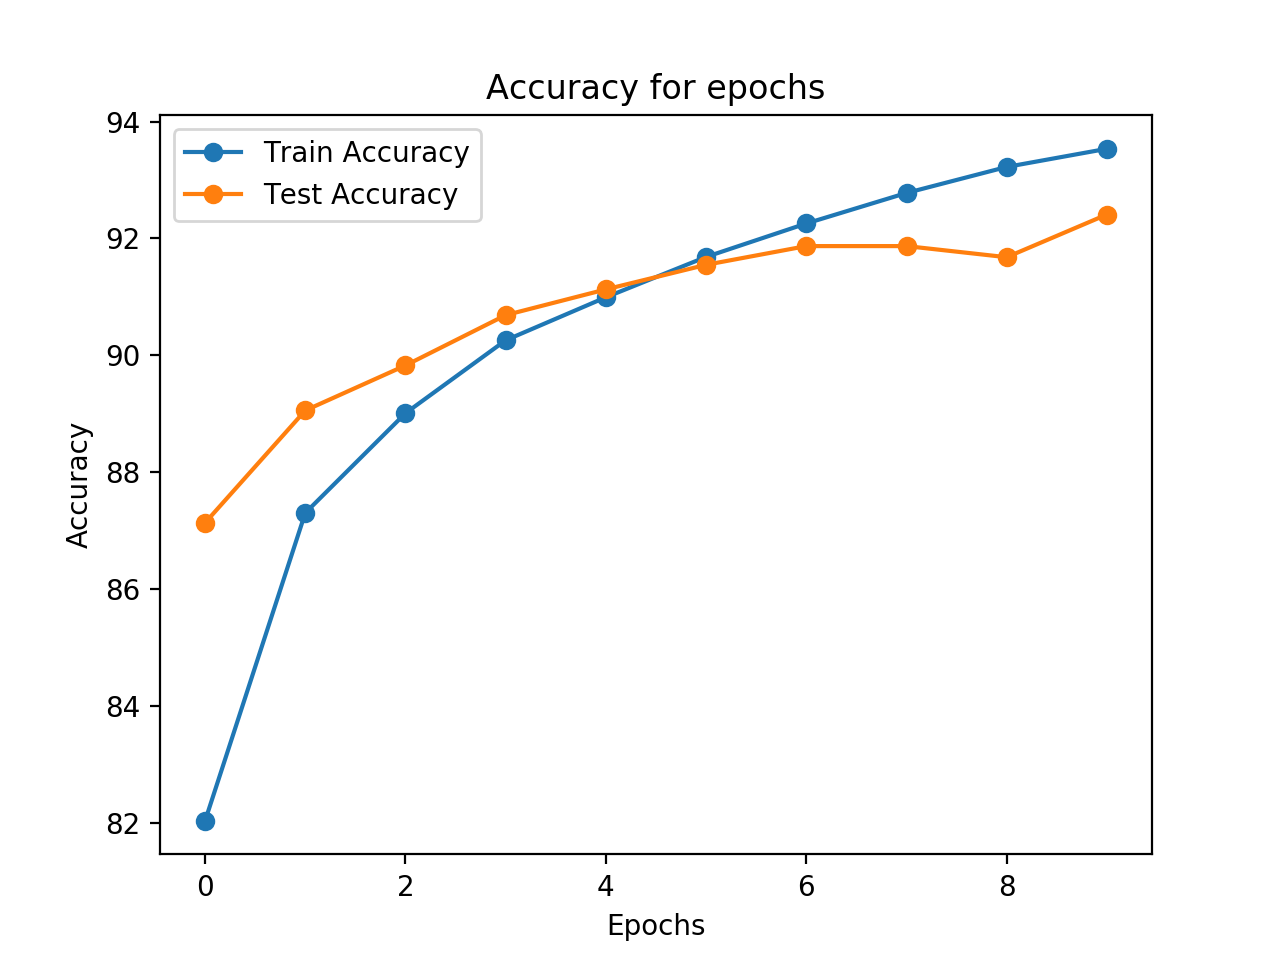

<IPython.core.display.Javascript object>


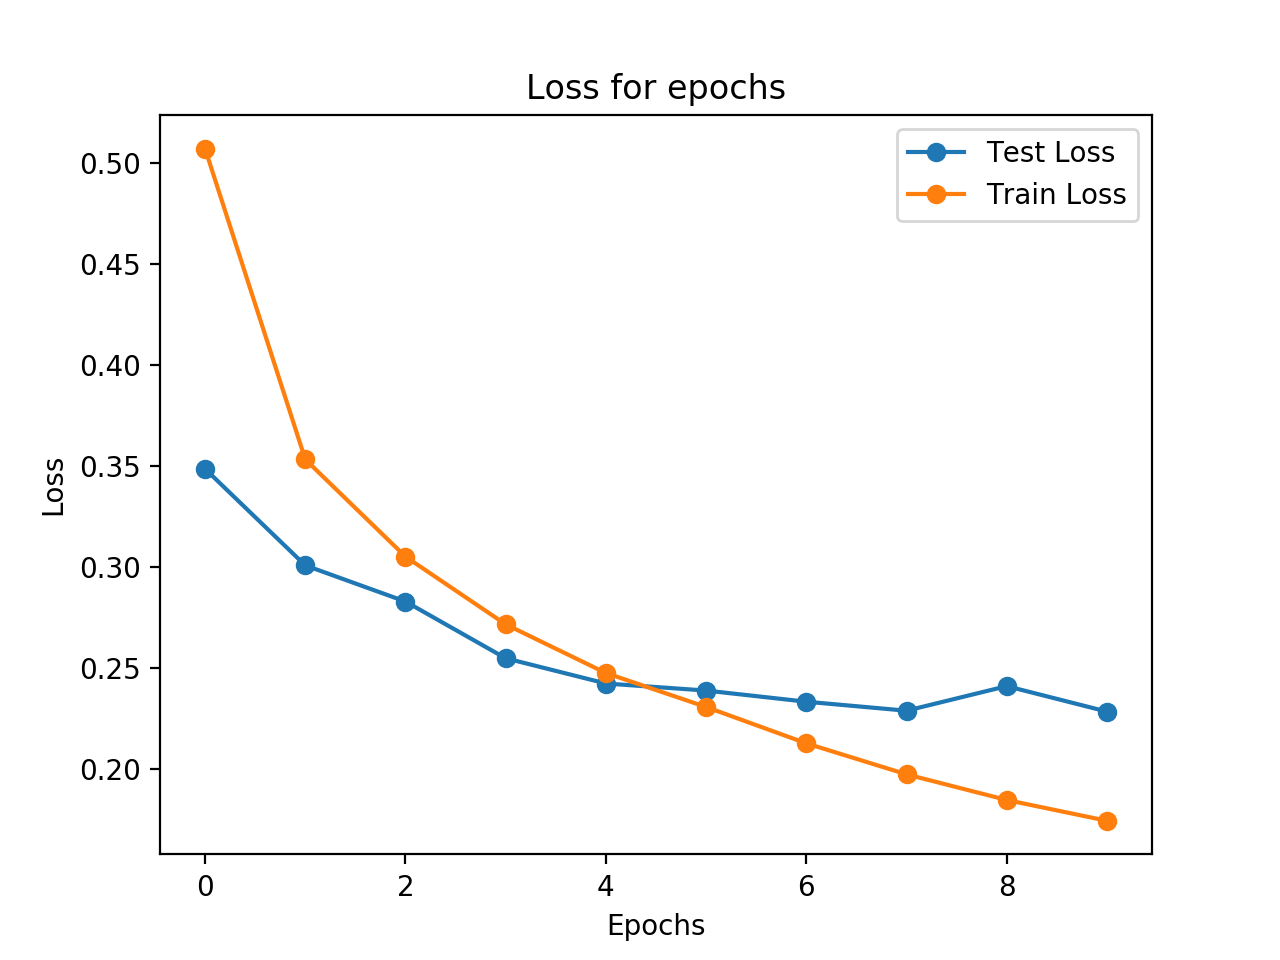

In [10]:
%matplotlib notebook
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for epochs')
plt.legend()

# Fashion MNIST Student architecture

In [46]:
temp=7
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,32)
        #self.fc2=nn.Linear(800,800)
        self.fc3=nn.Linear(32,10)
        #self.fc1.weight_orig=self.fc1.weight
        #del self.fc1.weight
        #self.fc2.weight_orig=self.fc2.weight
        #del self.fc2.weight
        #self.fc3.weight_orig=self.fc3.weight
        #del self.fc3.weight
    def forward(self,data):
        x=data.view(-1,28*28)
        #self.fc1.weight=getQuantizedWeights(self.fc1.weight_orig)
        #print(self.fc1.weight)
        x=F.relu(self.fc1(x))
        #self.fc2.weight=getQuantizedWeights(self.fc2.weight_orig)
        #print(self.fc2.weight)
        #x=F.relu(self.fc2(x))
        #self.fc3.weight=getQuantizedWeights(self.fc3.weight_orig)
        x=self.fc3(x)
        return x
def knowledgedistillationloss(outputs,labels,weightTeacher,alpha):
    return nn.KLDivLoss()(F.log_softmax(outputs/temp,dim=1),F.softmax(weightTeacher/temp,dim=1))+alpha*F.cross_entropy(outputs,labels)
'''def knowledgedistillationloss(studentLogits,teacherLogits,minibatchsize):
    return (1/2*minibatchsize)*(studentLogits-teacherLogits)'''
modelStudent=Student()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStudent.cuda()
optimizer=torch.optim.Adam(modelStudent.parameters(),lr=0.001)
def trainStudent(trainLoader):
    modelStudent.train()
    modelFashion.eval()
    runningloss=0.0
    correct=0
    total=0
    totalLoss=0
    for i,(data,labels) in enumerate(trainLoader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=modelStudent(data)
        weightTeacher=modelFashion(data)
        weightTeacher=weightTeacher.detach()
        loss=knowledgedistillationloss(predicted,labels,weightTeacher,0.1)
        #print(weightTeacher.shape,predicted.shape,labels.shape)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        #modelStudent.fc1.weight.grad_orig=modelStudent.fc1.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc2.weight.grad_orig=modelStudent.fc2.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc3.weight.grad_orig=modelStudent.fc3.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc1.weight.grad=getQuantizedWeights(modelStudent.fc1.weight.grad_orig)
        #modelStudent.fc2.weight.grad=getQuantizedWeights(modelStudent.fc2.weight.grad_orig)
        #modelStudent.fc3.weight.grad=getQuantizedWeights(modelStudent.fc3.weight.grad_orig)
        optimizer.step()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        totalLoss+=loss.item()
            #print(loss.item())
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return totalLoss/len(trainLoader),(correct/total)*100
                

In [27]:
##Fashion MNIST student architecture 2
temp=7
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,800)
        #self.fc2=nn.Linear(800,800)
        self.fc3=nn.Linear(800,10)
        #self.fc1.weight_orig=self.fc1.weight
        #del self.fc1.weight
        #self.fc2.weight_orig=self.fc2.weight
        #del self.fc2.weight
        #self.fc3.weight_orig=self.fc3.weight
        #del self.fc3.weight
    def forward(self,data):
        x=data.view(-1,28*28)
        #self.fc1.weight=getQuantizedWeights(self.fc1.weight_orig)
        #print(self.fc1.weight)
        x=F.relu(self.fc1(x))
        #self.fc2.weight=getQuantizedWeights(self.fc2.weight_orig)
        #print(self.fc2.weight)
        #x=F.relu(self.fc2(x))
        #self.fc3.weight=getQuantizedWeights(self.fc3.weight_orig)
        x=self.fc3(x)
        return x
def knowledgedistillationloss(outputs,labels,weightTeacher,alpha):
    return (temp**2)*nn.KLDivLoss()(F.log_softmax(outputs/temp,dim=1),F.softmax(weightTeacher/temp,dim=1))+alpha*F.cross_entropy(outputs,labels)
'''def knowledgedistillationloss(studentLogits,teacherLogits,minibatchsize):
    return (1/2*minibatchsize)*(studentLogits-teacherLogits)'''
modelStudent=Student()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStudent.cuda()
optimizer=torch.optim.Adam(modelStudent.parameters(),lr=0.001)
def trainStudent(trainLoader):
    modelStudent.train()
    modelFashion.eval()
    runningloss=0.0
    correct=0
    total=0
    totalLoss=0
    for i,(data,labels) in enumerate(trainLoader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=modelStudent(data)
        weightTeacher=modelFashion(data)
        weightTeacher=weightTeacher.detach()
        loss=knowledgedistillationloss(predicted,labels,weightTeacher,0.1)
        #print(weightTeacher.shape,predicted.shape,labels.shape)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        #modelStudent.fc1.weight.grad_orig=modelStudent.fc1.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc2.weight.grad_orig=modelStudent.fc2.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc3.weight.grad_orig=modelStudent.fc3.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc1.weight.grad=getQuantizedWeights(modelStudent.fc1.weight.grad_orig)
        #modelStudent.fc2.weight.grad=getQuantizedWeights(modelStudent.fc2.weight.grad_orig)
        #modelStudent.fc3.weight.grad=getQuantizedWeights(modelStudent.fc3.weight.grad_orig)
        optimizer.step()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        totalLoss+=loss.item()
            #print(loss.item())
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return totalLoss/len(trainLoader),(correct/total)*100
                

In [28]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        runningLoss=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=modelFashion(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
            runningLoss+=loss.item()
    return runningLoss/len(testLoader),(correct/total)*100

In [48]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainStudent(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.0813
epoch 1/10,batch 10000,loss=0.0632
epoch 1/10,batch 15000,loss=0.0596
epoch 2/10,batch 5000,loss=0.0541
epoch 2/10,batch 10000,loss=0.0500
epoch 2/10,batch 15000,loss=0.0514
epoch 3/10,batch 5000,loss=0.0483
epoch 3/10,batch 10000,loss=0.0480
epoch 3/10,batch 15000,loss=0.0461
epoch 4/10,batch 5000,loss=0.0443
epoch 4/10,batch 10000,loss=0.0451
epoch 4/10,batch 15000,loss=0.0449
epoch 5/10,batch 5000,loss=0.0425
epoch 5/10,batch 10000,loss=0.0428
epoch 5/10,batch 15000,loss=0.0431
epoch 6/10,batch 5000,loss=0.0408
epoch 6/10,batch 10000,loss=0.0419
epoch 6/10,batch 15000,loss=0.0420
epoch 7/10,batch 5000,loss=0.0395
epoch 7/10,batch 10000,loss=0.0404
epoch 7/10,batch 15000,loss=0.0409
epoch 8/10,batch 5000,loss=0.0382
epoch 8/10,batch 10000,loss=0.0404
epoch 8/10,batch 15000,loss=0.0393
epoch 9/10,batch 5000,loss=0.0374
epoch 9/10,batch 10000,loss=0.0392
epoch 9/10,batch 15000,loss=0.0393
epoch 10/10,batch 5000,loss=0.0368
epoch 10/10,batch 10000,loss=

In [31]:
##Fashion mnist second architecture
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainStudent(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.0780
epoch 1/10,batch 10000,loss=0.0572
epoch 1/10,batch 15000,loss=0.0525
epoch 2/10,batch 5000,loss=0.0472
epoch 2/10,batch 10000,loss=0.0475
epoch 2/10,batch 15000,loss=0.0460
epoch 3/10,batch 5000,loss=0.0431
epoch 3/10,batch 10000,loss=0.0429
epoch 3/10,batch 15000,loss=0.0416
epoch 4/10,batch 5000,loss=0.0398
epoch 4/10,batch 10000,loss=0.0397
epoch 4/10,batch 15000,loss=0.0396
epoch 5/10,batch 5000,loss=0.0376
epoch 5/10,batch 10000,loss=0.0380
epoch 5/10,batch 15000,loss=0.0385
epoch 6/10,batch 5000,loss=0.0350
epoch 6/10,batch 10000,loss=0.0370
epoch 6/10,batch 15000,loss=0.0371
epoch 7/10,batch 5000,loss=0.0341
epoch 7/10,batch 10000,loss=0.0346
epoch 7/10,batch 15000,loss=0.0360
epoch 8/10,batch 5000,loss=0.0334
epoch 8/10,batch 10000,loss=0.0336
epoch 8/10,batch 15000,loss=0.0347
epoch 9/10,batch 5000,loss=0.0319
epoch 9/10,batch 10000,loss=0.0328
epoch 9/10,batch 15000,loss=0.0343
epoch 10/10,batch 5000,loss=0.0312
epoch 10/10,batch 10000,loss=

In [29]:
##Duplicate again again(multiply by the temp)
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainStudent(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.4462
epoch 1/10,batch 10000,loss=0.2893
epoch 1/10,batch 15000,loss=0.2471
epoch 2/10,batch 5000,loss=0.2257
epoch 2/10,batch 10000,loss=0.2126
epoch 2/10,batch 15000,loss=0.2062
epoch 3/10,batch 5000,loss=0.1908
epoch 3/10,batch 10000,loss=0.1848
epoch 3/10,batch 15000,loss=0.1871
epoch 4/10,batch 5000,loss=0.1727
epoch 4/10,batch 10000,loss=0.1716
epoch 4/10,batch 15000,loss=0.1772
epoch 5/10,batch 5000,loss=0.1635
epoch 5/10,batch 10000,loss=0.1649
epoch 5/10,batch 15000,loss=0.1637
epoch 6/10,batch 5000,loss=0.1554
epoch 6/10,batch 10000,loss=0.1556
epoch 6/10,batch 15000,loss=0.1616
epoch 7/10,batch 5000,loss=0.1492
epoch 7/10,batch 10000,loss=0.1523
epoch 7/10,batch 15000,loss=0.1537
epoch 8/10,batch 5000,loss=0.1445
epoch 8/10,batch 10000,loss=0.1471
epoch 8/10,batch 15000,loss=0.1482
epoch 9/10,batch 5000,loss=0.1408
epoch 9/10,batch 10000,loss=0.1452
epoch 9/10,batch 15000,loss=0.1424
epoch 10/10,batch 5000,loss=0.1369
epoch 10/10,batch 10000,loss=

In [49]:
print(f'Train accuracy={trainaccuracy[len(testaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=88.43833333333333
Test accuracy=86.18


In [32]:
##Fashion mnist second architecture
print(f'Train accuracy={trainaccuracy[len(testaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=89.95333333333333
Test accuracy=87.48


In [30]:
##Duplicate again again(multiply with temp)
print(f'Train accuracy={trainaccuracy[len(testaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=90.85666666666667
Test accuracy=88.38000000000001


In [22]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'Total number of parameters of Teacher model is {pytorch_total_params}')
print(f'The total space occupied by this model is {(pytorch_total_params*4)} bytes')

Total number of parameters of Teacher model is 25450
The total space occupied by this model is 101800 bytes


In [33]:
##Fashion mnist second architecture
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'Total number of parameters of Teacher model is {pytorch_total_params}')
print(f'The total space occupied by this model is {(pytorch_total_params*4)} bytes')

Total number of parameters of Teacher model is 636010
The total space occupied by this model is 2544040 bytes


In [ ]:
torch.save(modelStudent.state_dict(),'./mnistFashion_student.pth')

<IPython.core.display.Javascript object>


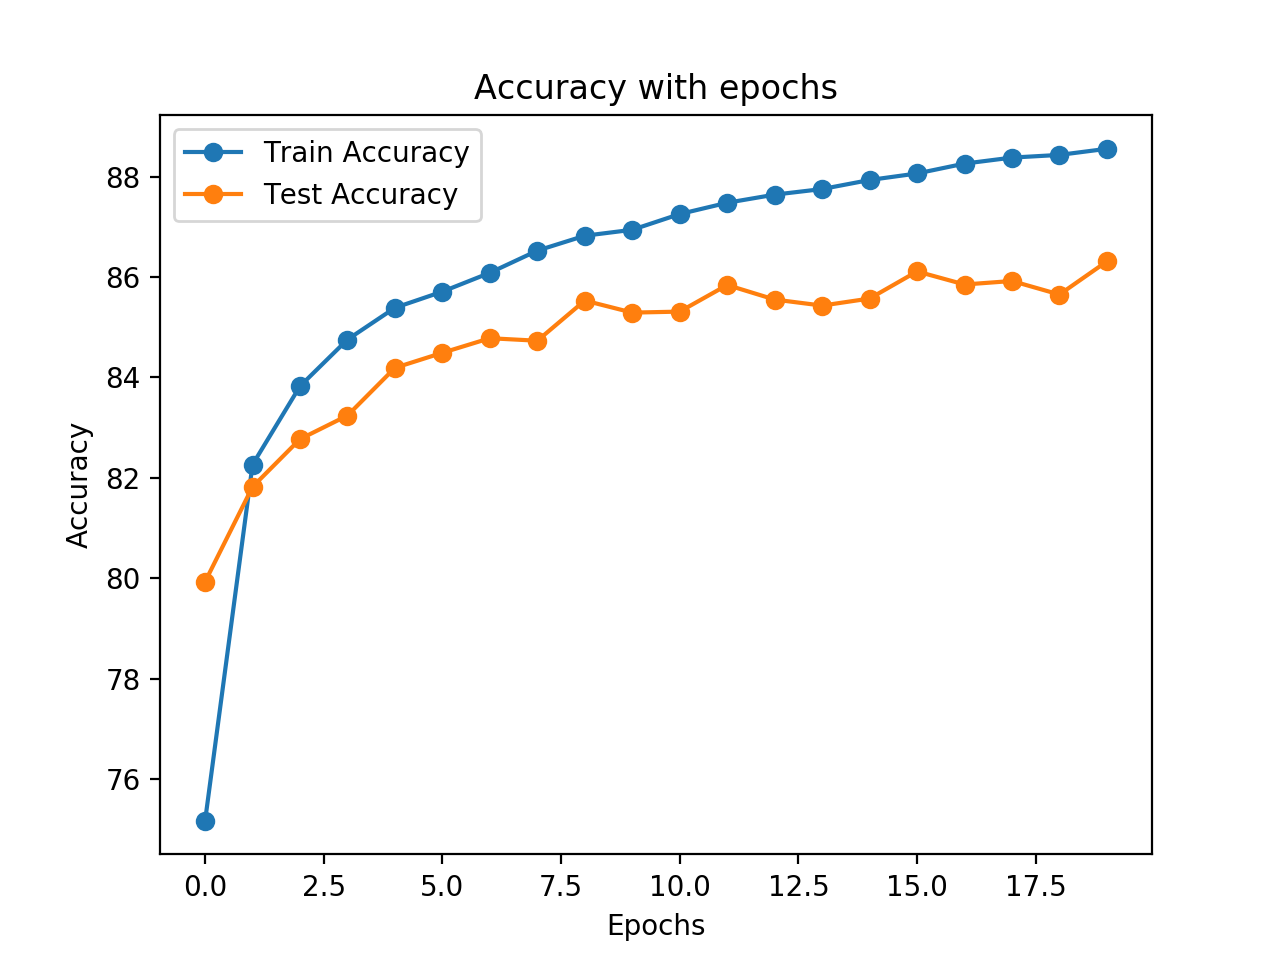

<IPython.core.display.Javascript object>


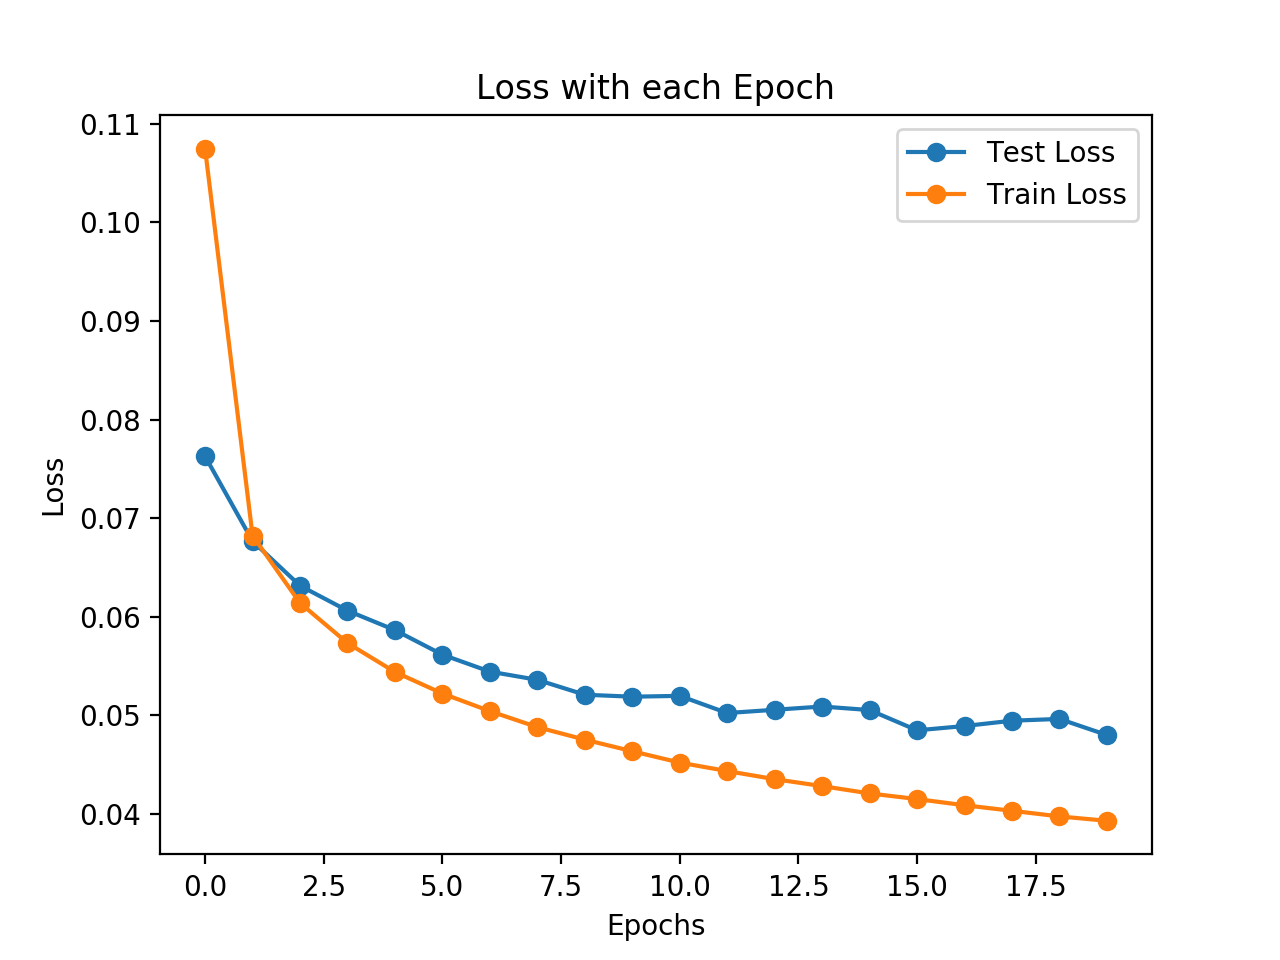

In [23]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

# Fashion MNIST student network Quantization

In [31]:
##When quantizating with first architecture use the number of clusters in the weight matrix as 10 and the bias matrix as 4
##When quantizating with second architecture use the number of clusters in the weight matrix as 400 and the bias matrix as 100 for first fully connected layer and 4 for second layer
def getQuantizedWeights(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0]*weightCopy.shape[1],-1)).reshape(weightCopy.shape[0],weightCopy.shape[1])
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight[i][j]=torch.from_numpy(kmeans.cluster_centers_[labels[i][j]])
        #print(weight)
    return weight
modelStudent.fc1.weight_orig=modelStudent.fc1.weight
#print(modelStudent.fc1.weight_orig)
#del modelStudent.fc1.weight
#modelStudent.fc2.weight_orig=modelStudent.fc2.weight
#del modelStudent.fc2.weight
modelStudent.fc3.weight_orig=modelStudent.fc3.weight
#del modelStudent.fc3.weight
modelStudent.fc1.weight=getQuantizedWeights(modelStudent.fc1.weight_orig,400)
#modelStudent.fc2.weight=getQuantizedWeights(modelStudent.fc2.weight_orig,10)
modelStudent.fc3.weight=getQuantizedWeights(modelStudent.fc3.weight_orig,400)

In [32]:
def getQuantizedWeightsBias(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        #print(weightCopy.view(weightCopy.shape[0],-1).shape)
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0],-1))
        #print(labels)
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            weight[i]=torch.from_numpy(kmeans.cluster_centers_[labels[i]])
    return weight
modelStudent.fc1.bias_orig=modelStudent.fc1.bias
#print(modelStudent.fc1.bias_orig)
#del modelStudent.fc1.bias
#modelStudent.fc2.bias_orig=modelStudent.fc2.bias
#del modelStudent.fc2.weight
modelStudent.fc3.bias_orig=modelStudent.fc3.bias
#del modelStudent.fc3.bias
#print(getQuantizedWeightsBias(modelStudent.fc1.bias_orig,4))
modelStudent.fc1.bias=getQuantizedWeightsBias(modelStudent.fc1.bias_orig,100)
#modelStudent.fc2.bias=getQuantizedWeightsBias(modelStudent.fc2.bias_orig,4)
modelStudent.fc3.bias=getQuantizedWeightsBias(modelStudent.fc3.bias_orig,4)
#print(modelStudent.fc1.bias)

In [56]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=modelFashion(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderFashionMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=8489.0,accuracy=84.89


In [37]:
##Fashion MNIST second architecture
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=modelFashion(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderFashionMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=8745.0,accuracy=87.45


In [33]:
##Fashion MNIST second architecture(multiply by temp)
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=modelFashion(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderFashionMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=8823.0,accuracy=88.23


In [26]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(pytorch_total_params)
additional_storage=(2*32*10)+(2*4*32)
print(f'Total size of the file is {(pytorch_total_params/2)+(additional_storage/8)} bytes')

25450
Total size of the file is 12837.0 bytes


In [53]:
##Fashion MNIST second architecture
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(pytorch_total_params)

636010


In [51]:
additional_storage=(2*32*9)+(2*32)+(32*8)
print(f'Total size of the file is {((636010*9)/8)+(additional_storage/8)} bytes')

Total size of the file is 715623.25 bytes


In [34]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(pytorch_total_params)
additional_storage=(2*32*9)+(2*32)+(32*8)
print(f'Total size of the file is {((pytorch_total_params*9)/8)+(additional_storage/8)} bytes')

636010
Total size of the file is 715623.25 bytes


In [68]:
class StandaloneStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,32)
        
        self.fc3=nn.Linear(32,10)
       
    def forward(self,data):
        x=data.view(-1,28*28)

        x=F.relu(self.fc1(x))
        
        x=self.fc3(x)
        return x
modelStandaloneStudentFashion=StandaloneStudent()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStandaloneStudentFashion.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(modelStandaloneStudentFashion.parameters(),lr=0.001)
def train(loader):
    modelStandaloneStudentFashion.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    runninglosstotal=0.0
    for i,(image,labels) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=modelStandaloneStudentFashion(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        runninglosstotal+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return runninglosstotal/len(loader),(correct/total)*100

In [35]:
##Standalone Student Network fashion MNIST second architecture
class StandaloneStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,800)
        
        self.fc3=nn.Linear(800,10)
       
    def forward(self,data):
        x=data.view(-1,28*28)

        x=F.relu(self.fc1(x))
        
        x=self.fc3(x)
        return x
modelStandaloneStudentFashion=StandaloneStudent()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStandaloneStudentFashion.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(modelStandaloneStudentFashion.parameters(),lr=0.001)
def train(loader):
    modelStandaloneStudentFashion.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    runninglosstotal=0.0
    for i,(image,labels) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=modelStandaloneStudentFashion(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        runninglosstotal+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return runninglosstotal/len(loader),(correct/total)*100

In [36]:
def testMNIST(loader):
    with torch.no_grad():
        modelStandaloneStudentFashion.eval()
        correct=0
        total=0
        runningLoss=0
        for i,(image,labels) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=modelStandaloneStudentFashion(image)
            loss=criterion(prediction,labels)
            runningLoss+=loss.item()
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
    return runningLoss/len(loader),(correct/total)*100

In [70]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=5
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/5,batch 5000,loss=0.5789
epoch 1/5,batch 10000,loss=0.4669
epoch 1/5,batch 15000,loss=0.4526
epoch 2/5,batch 5000,loss=0.4131
epoch 2/5,batch 10000,loss=0.4055
epoch 2/5,batch 15000,loss=0.4091
epoch 3/5,batch 5000,loss=0.3801
epoch 3/5,batch 10000,loss=0.3860
epoch 3/5,batch 15000,loss=0.3798
epoch 4/5,batch 5000,loss=0.3669
epoch 4/5,batch 10000,loss=0.3575
epoch 4/5,batch 15000,loss=0.3641
epoch 5/5,batch 5000,loss=0.3479
epoch 5/5,batch 10000,loss=0.3525
epoch 5/5,batch 15000,loss=0.3534


In [41]:
##Fashion MNIST standalone student second architecture
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=5
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/5,batch 5000,loss=0.5962
epoch 1/5,batch 10000,loss=0.4742
epoch 1/5,batch 15000,loss=0.4342
epoch 2/5,batch 5000,loss=0.4076
epoch 2/5,batch 10000,loss=0.3996
epoch 2/5,batch 15000,loss=0.3861
epoch 3/5,batch 5000,loss=0.3640
epoch 3/5,batch 10000,loss=0.3715
epoch 3/5,batch 15000,loss=0.3611
epoch 4/5,batch 5000,loss=0.3399
epoch 4/5,batch 10000,loss=0.3508
epoch 4/5,batch 15000,loss=0.3589
epoch 5/5,batch 5000,loss=0.3323
epoch 5/5,batch 10000,loss=0.3399
epoch 5/5,batch 15000,loss=0.3393


In [37]:
##Fashion MNIST standalone student second architecture(mulltiply by temperature)
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.5945
epoch 1/10,batch 10000,loss=0.4808
epoch 1/10,batch 15000,loss=0.4325
epoch 2/10,batch 5000,loss=0.3941
epoch 2/10,batch 10000,loss=0.4067
epoch 2/10,batch 15000,loss=0.3902
epoch 3/10,batch 5000,loss=0.3711
epoch 3/10,batch 10000,loss=0.3682
epoch 3/10,batch 15000,loss=0.3625
epoch 4/10,batch 5000,loss=0.3421
epoch 4/10,batch 10000,loss=0.3597
epoch 4/10,batch 15000,loss=0.3540
epoch 5/10,batch 5000,loss=0.3312
epoch 5/10,batch 10000,loss=0.3435
epoch 5/10,batch 15000,loss=0.3349
epoch 6/10,batch 5000,loss=0.3185
epoch 6/10,batch 10000,loss=0.3307
epoch 6/10,batch 15000,loss=0.3220
epoch 7/10,batch 5000,loss=0.3114
epoch 7/10,batch 10000,loss=0.3232
epoch 7/10,batch 15000,loss=0.3091
epoch 8/10,batch 5000,loss=0.2956
epoch 8/10,batch 10000,loss=0.3217
epoch 8/10,batch 15000,loss=0.3146
epoch 9/10,batch 5000,loss=0.2988
epoch 9/10,batch 10000,loss=0.2951
epoch 9/10,batch 15000,loss=0.3031
epoch 10/10,batch 5000,loss=0.2831
epoch 10/10,batch 10000,loss=

In [71]:
print(f'Train accuracy={trainaccuracy[len(testaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=87.22166666666666
Test accuracy=85.19


In [42]:
##Fashion MNIST standalone student second architecture
print(f'Train accuracy={trainaccuracy[len(testaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=87.86166666666666
Test accuracy=86.75


In [38]:
##Fashion MNIST standalone student second architecture(multiply by temperature)
print(f'Train accuracy={trainaccuracy[len(testaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=89.05333333333333
Test accuracy=86.39


In [72]:
def getQuantizedWeights(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0]*weightCopy.shape[1],-1)).reshape(weightCopy.shape[0],weightCopy.shape[1])
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight[i][j]=torch.from_numpy(kmeans.cluster_centers_[labels[i][j]])
        #print(weight)
    return weight
modelStandaloneStudentFashion.fc1.weight_orig=modelStandaloneStudentFashion.fc1.weight
#print(modelStudent.fc1.weight_orig)
#del modelStudent.fc1.weight
#modelStudent.fc2.weight_orig=modelStudent.fc2.weight
#del modelStudent.fc2.weight
modelStandaloneStudentFashion.fc3.weight_orig=modelStandaloneStudentFashion.fc3.weight
#del modelStudent.fc3.weight
modelStandaloneStudentFashion.fc1.weight=getQuantizedWeights(modelStandaloneStudentFashion.fc1.weight_orig,10)
#modelStudent.fc2.weight=getQuantizedWeights(modelStudent.fc2.weight_orig,10)
modelStandaloneStudentFashion.fc3.weight=getQuantizedWeights(modelStandaloneStudentFashion.fc3.weight_orig,10)

In [73]:
def getQuantizedWeightsBias(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        #print(weightCopy.view(weightCopy.shape[0],-1).shape)
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0],-1))
        #print(labels)
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            weight[i]=torch.from_numpy(kmeans.cluster_centers_[labels[i]])
    return weight
modelStandaloneStudentFashion.fc1.bias_orig=modelStandaloneStudentFashion.fc1.bias
#print(modelStudent.fc1.bias_orig)
#del modelStudent.fc1.bias
#modelStudent.fc2.bias_orig=modelStudent.fc2.bias
#del modelStudent.fc2.weight
modelStandaloneStudentFashion.fc3.bias_orig=modelStandaloneStudentFashion.fc3.bias
#del modelStudent.fc3.bias
#print(getQuantizedWeightsBias(modelStudent.fc1.bias_orig,4))
modelStandaloneStudentFashion.fc1.bias=getQuantizedWeightsBias(modelStandaloneStudentFashion.fc1.bias_orig,4)
#modelStudent.fc2.bias=getQuantizedWeightsBias(modelStudent.fc2.bias_orig,4)
modelStandaloneStudentFashion.fc3.bias=getQuantizedWeightsBias(modelStandaloneStudentFashion.fc3.bias_orig,4)
#print(modelStudent.fc1.bias)

In [75]:
def testMNIST(loader):
    with torch.no_grad():
        modelStandaloneStudentFashion.eval()
        correct=0
        total=0
        runningLoss=0
        for i,(image,labels) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=modelStandaloneStudentFashion(image)
            loss=criterion(prediction,labels)
            runningLoss+=loss.item()
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testMNIST(testLoaderFashionMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=8413,accuracy=84.13000000000001


# CIFAR 10

In [7]:
trainSetCifar=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
testSetCifar=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainLoaderCifar=DataLoader(dataset=trainSetCifar,batch_size=32,shuffle=True)
testLoaderCifar=DataLoader(dataset=testSetCifar,batch_size=32,shuffle=False)

In [9]:
vgg=models.vgg16(pretrained=True)

In [10]:
use_cuda=True
if use_cuda and torch.cuda.is_available():
    vgg.cuda()
vgg.classifier[6]=nn.Sequential(nn.Linear(4096,10))
for param in vgg.features.parameters():
    param.requires_grad=False
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
if use_cuda and torch.cuda.is_available():
    vgg.cuda()
epochs=15
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(vgg.classifier.parameters(),lr=0.001,momentum=0.9)
def trainCifar(loader):
    vgg.train()
    correct=0
    total=0
    runningloss=0
    totalLoss=0.0
    for i,(data,label) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            label=label.cuda()
        optimizer.zero_grad()
        prediction=vgg(data)
        loss=criterion(prediction,label)
        loss.backward()
        optimizer.step()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==label).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        totalLoss+=loss.item()
        if i%500==499:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/500}')
            runningloss=0.0
    return totalLoss/len(loader),(correct/total)*100

In [12]:
def testCifar(loader):
    vgg.eval()
    with torch.no_grad():
        correct=0
        total=0
        runningLoss=0.0
        for i,(data,label) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                label=label.cuda()
            prediction=vgg(data)
            loss=criterion(prediction,label)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==label).sum().item()
            total+=data.shape[0]
            runningLoss+=loss.item()
    return runningLoss/len(loader),(correct/total)*100

In [13]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=15
for epoch in range(epochs):
    loss,accuracy=trainCifar(trainLoaderCifar)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testCifar(testLoaderCifar)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/15,batch 500,loss=0.862319171667099
epoch 1/15,batch 1000,loss=0.6168476569056511
epoch 1/15,batch 1500,loss=0.5616072985231877
epoch 2/15,batch 500,loss=0.47052342200279235
epoch 2/15,batch 1000,loss=0.45576336720585825
epoch 2/15,batch 1500,loss=0.4307356666326523
epoch 3/15,batch 500,loss=0.37253082947432997
epoch 3/15,batch 1000,loss=0.36064274752140046
epoch 3/15,batch 1500,loss=0.3496834920346737
epoch 4/15,batch 500,loss=0.2951154846698046
epoch 4/15,batch 1000,loss=0.2905064392387867
epoch 4/15,batch 1500,loss=0.29071062049269675
epoch 5/15,batch 500,loss=0.2272231165319681
epoch 5/15,batch 1000,loss=0.22621005514264106
epoch 5/15,batch 1500,loss=0.23020815359055996
epoch 6/15,batch 500,loss=0.18074152232706547
epoch 6/15,batch 1000,loss=0.178810425311327
epoch 6/15,batch 1500,loss=0.17680510188639165
epoch 7/15,batch 500,loss=0.13726061257719993
epoch 7/15,batch 1000,loss=0.13103929993510247
epoch 7/15,batch 1500,loss=0.13344667495787144
epoch 8/15,batch 500,loss=0.097

In [14]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=99.568
Test accuracy=87.46000000000001


In [15]:
pytorch_total_params = sum(p.numel() for p in vgg.parameters())
print(f'The Total number of parameters of the Teacher Model is {pytorch_total_params}')
#additional_storage=(3*16*10)+(3*4*16)
print(f'Total size of the file is {pytorch_total_params*4} bytes')

The Total number of parameters of the Teacher Model is 134301514
Total size of the file is 537206056 bytes


<IPython.core.display.Javascript object>


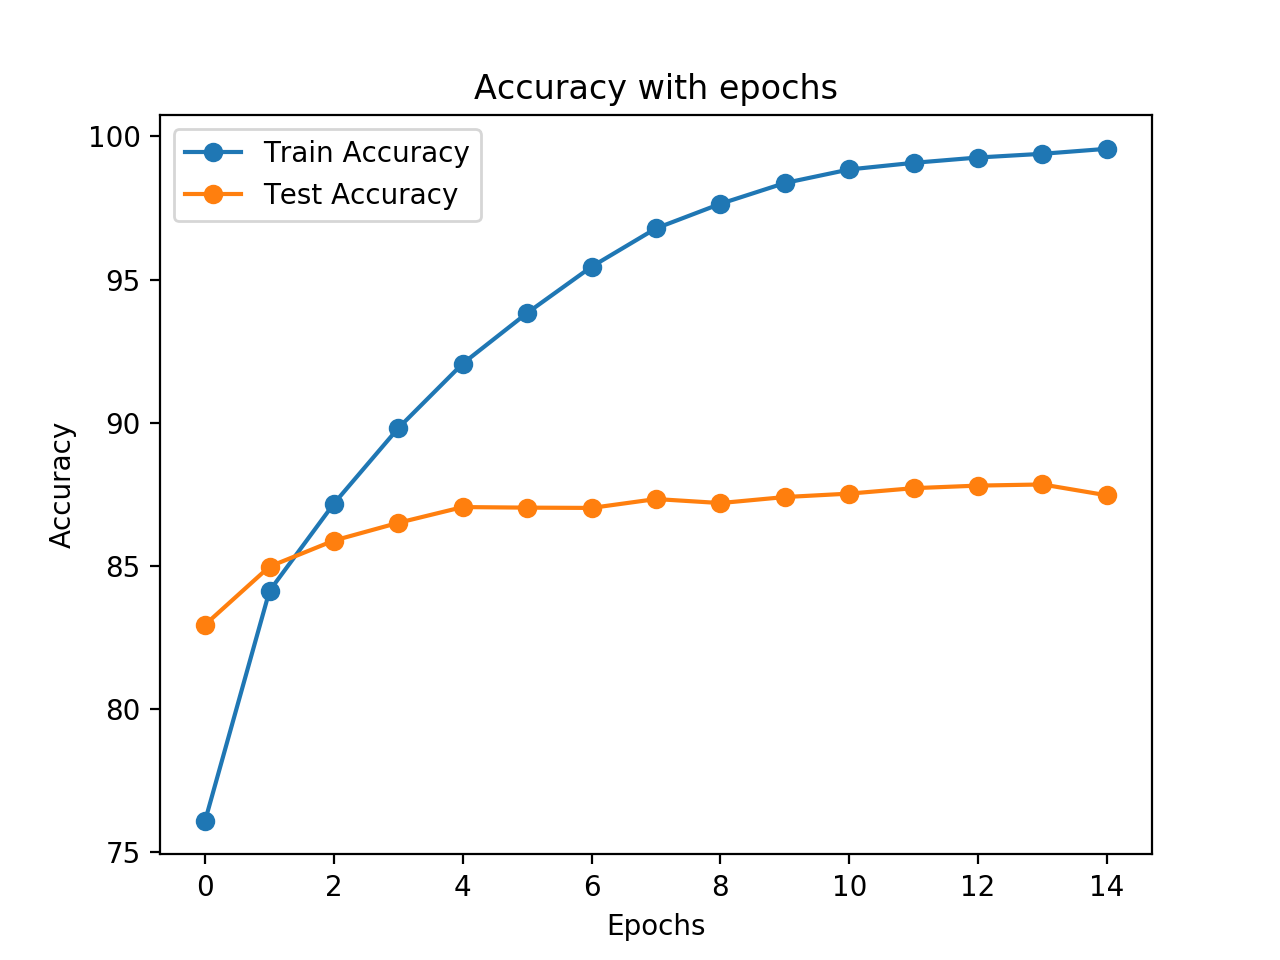

<IPython.core.display.Javascript object>


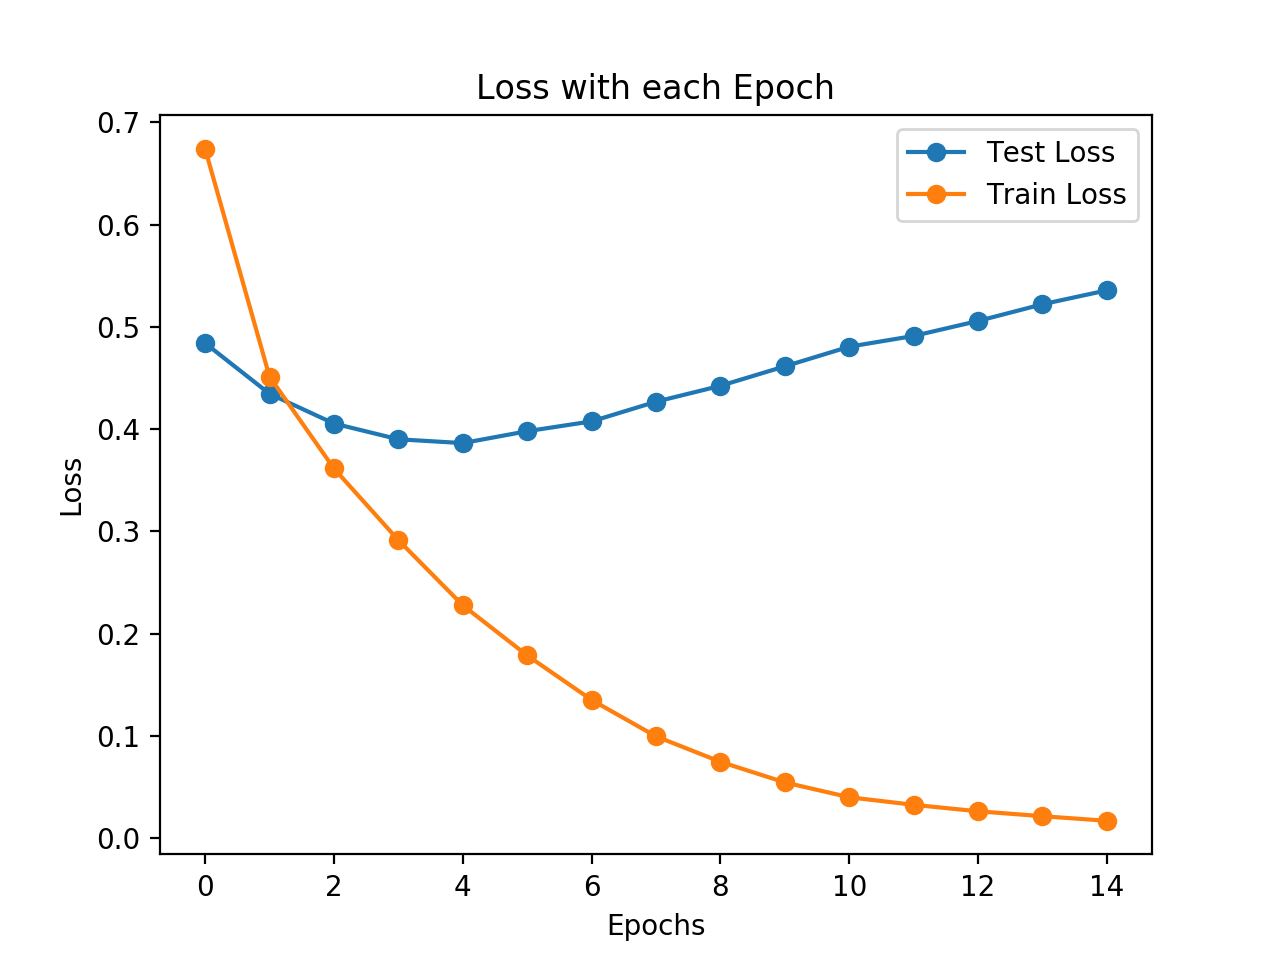

In [16]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

In [17]:
alexNet=models.alexnet()
alexNet.classifier[6]=nn.Sequential(nn.Linear(4096,10))
print(alexNet)
for param in alexNet.parameters():
    param.requires_grad=True

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
epochs=20
temp=7
def knowledgedistillationloss(outputs,labels,weightTeacher,alpha):
    return (temp**2)*nn.KLDivLoss()(F.log_softmax(outputs/temp,dim=1),F.softmax(weightTeacher/temp,dim=1))+alpha*F.cross_entropy(outputs,labels)
if use_cuda and torch.cuda.is_available():
    alexNet.cuda()
optimizer=torch.optim.SGD(alexNet.parameters(),lr=0.001,momentum=0.9)
def train(loader):
    alexNet.train()
    vgg.eval()
    runningloss=0.0
    correct=0
    total=0
    for i,(data,labels) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=alexNet(data)
        weightTeacher=vgg(data)
        weightTeacher=weightTeacher.detach()
        #print(weightTeacher.shape,predicted.shape,labels.shape)
        loss=knowledgedistillationloss(predicted,labels,weightTeacher,0.1)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        optimizer.step()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        #print(loss.item())
        if i%500==499:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/500:.4f}')
            runningloss=0.0
    return loss.item(),(correct/total)*100
                

In [19]:
def test(loader):
    alexNet.eval()
    vgg.eval()
    with torch.no_grad():
        correct=0
        total=0
        for i,(data,label) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                label=label.cuda()
            prediction=alexNet(data)
            weightTeacher=vgg(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,label,weightTeacher,0.1)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==label).sum().item()
            total+=data.shape[0]
    return loss.item(),(correct/total)*100





In [20]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=20
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderCifar)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=test(testLoaderCifar)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/20,batch 500,loss=4.6546
epoch 1/20,batch 1000,loss=4.6572
epoch 1/20,batch 1500,loss=4.6946
epoch 2/20,batch 500,loss=4.6570
epoch 2/20,batch 1000,loss=4.4762
epoch 2/20,batch 1500,loss=4.0135
epoch 3/20,batch 500,loss=3.3367
epoch 3/20,batch 1000,loss=3.1226
epoch 3/20,batch 1500,loss=2.9594
epoch 4/20,batch 500,loss=2.7190
epoch 4/20,batch 1000,loss=2.5133
epoch 4/20,batch 1500,loss=2.3662
epoch 5/20,batch 500,loss=2.1793
epoch 5/20,batch 1000,loss=2.0825
epoch 5/20,batch 1500,loss=1.9500
epoch 6/20,batch 500,loss=1.7788
epoch 6/20,batch 1000,loss=1.6737
epoch 6/20,batch 1500,loss=1.5880
epoch 7/20,batch 500,loss=1.4590
epoch 7/20,batch 1000,loss=1.3726
epoch 7/20,batch 1500,loss=1.3652
epoch 8/20,batch 500,loss=1.2530
epoch 8/20,batch 1000,loss=1.2022
epoch 8/20,batch 1500,loss=1.1721
epoch 9/20,batch 500,loss=1.0937
epoch 9/20,batch 1000,loss=1.0670
epoch 9/20,batch 1500,loss=1.0425
epoch 10/20,batch 500,loss=0.9777
epoch 10/20,batch 1000,loss=0.9702
epoch 10/20,batch 1500

In [21]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=90.114
Test accuracy=84.57000000000001


<IPython.core.display.Javascript object>


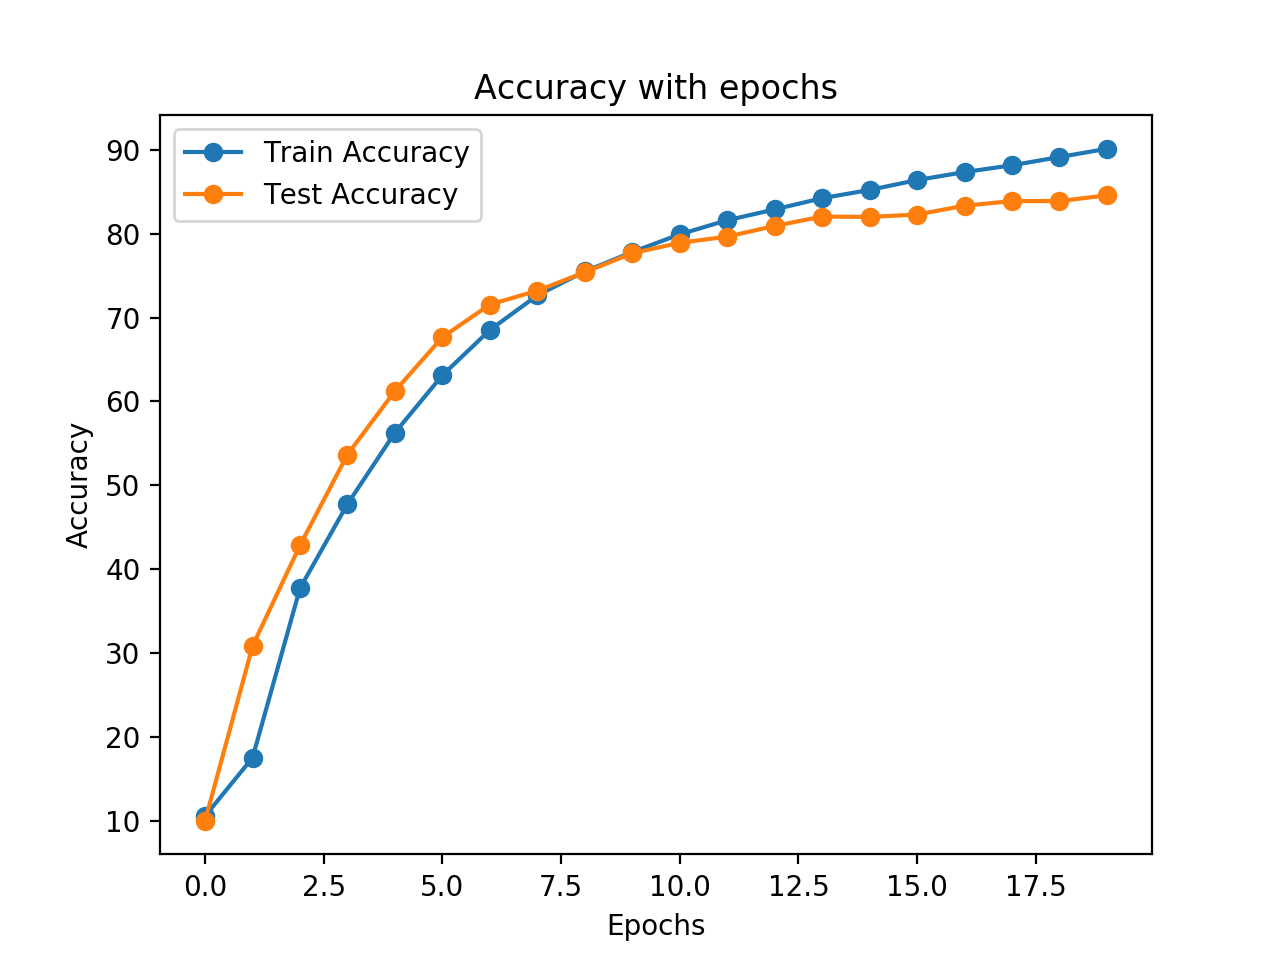

<IPython.core.display.Javascript object>


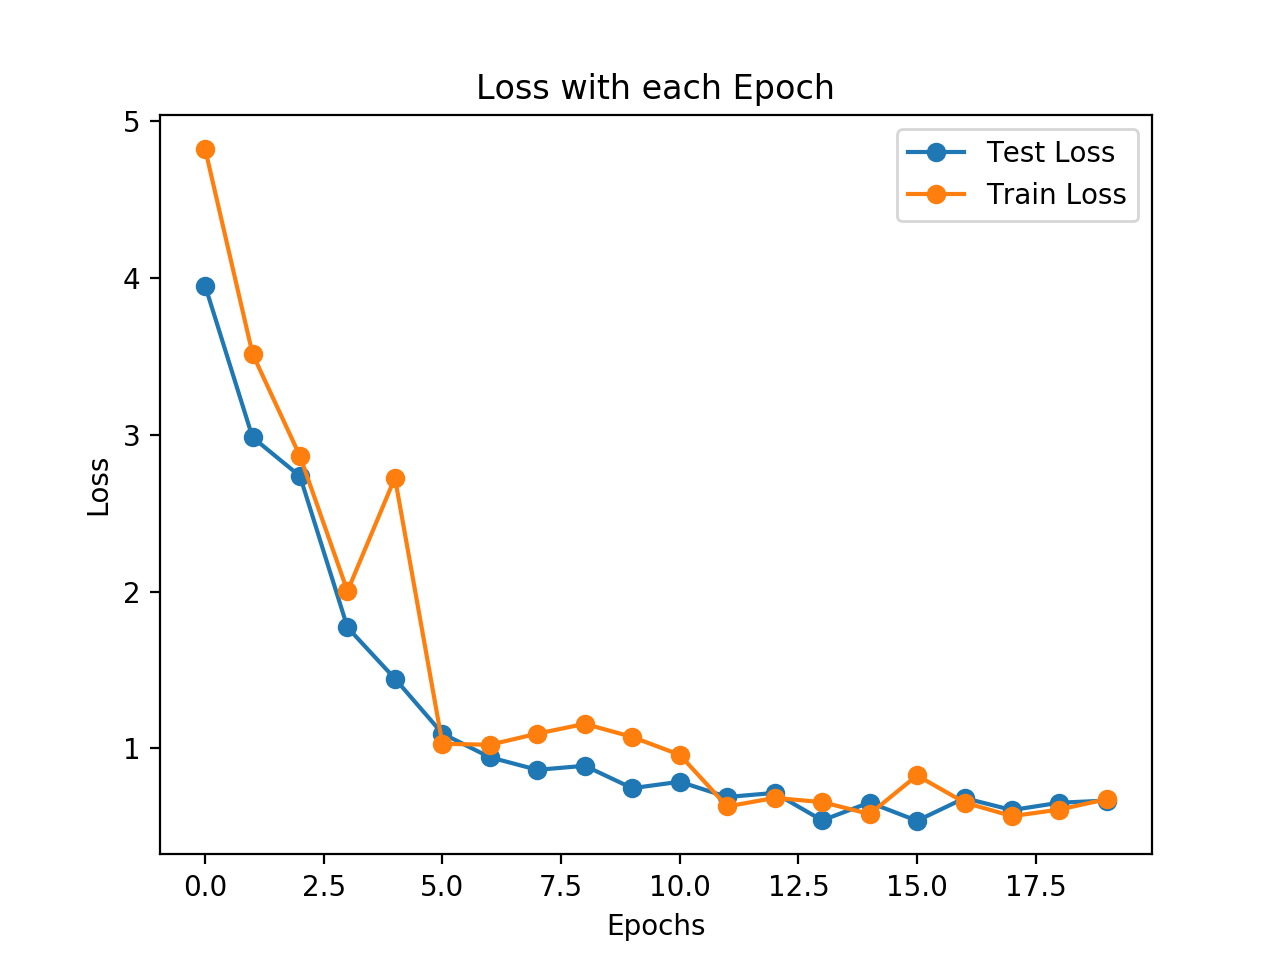

In [22]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

In [23]:
pytorch_total_params = sum(p.numel() for p in alexNet.parameters())
print(f'The total number of Parameters of the Student model before Quantizatoion is {pytorch_total_params}')
#additional_storage=(3*32*10)+(3*32*4)
#print(f'Total size of the file is {(pytorch_total_params/2)+(additional_storage/8)} bytes')
print(f'Total size of the file is {(pytorch_total_params*4)} bytes')

The total number of Parameters of the Student model before Quantizatoion is 57044810
Total size of the file is 228179240 bytes


In [24]:
def getQuantizedWeights(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0]*weightCopy.shape[1],-1)).reshape(weightCopy.shape[0],weightCopy.shape[1])
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight[i][j]=torch.from_numpy(kmeans.cluster_centers_[labels[i][j]])
        #print(weight)
    return weight
alexNet.classifier[1].weight=getQuantizedWeights(alexNet.classifier[1].weight,10)
#print(new_models.classifier[1].weight)
alexNet.classifier[4].weight=getQuantizedWeights(alexNet.classifier[4].weight,10)
alexNet.classifier[6][0].weight=getQuantizedWeights(alexNet.classifier[6][0].weight,10)

In [25]:
def getQuantizedWeightsBias(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        #print(weightCopy.view(weightCopy.shape[0],-1).shape)
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0],-1))
        #print(labels)
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            weight[i]=torch.from_numpy(kmeans.cluster_centers_[labels[i]])
    return weight

alexNet.classifier[1].bias=getQuantizedWeightsBias(alexNet.classifier[1].bias,4)
#print(new_models.classifier[1].weight)
alexNet.classifier[4].bias=getQuantizedWeightsBias(alexNet.classifier[4].bias,4)
alexNet.classifier[6][0].bias=getQuantizedWeightsBias(alexNet.classifier[6][0].bias,4)

In [26]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=alexNet(data)
            weightTeacher=vgg(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderCifar)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=8444.0,accuracy=84.44


In [27]:
pytorch_total_params_features = sum(p.numel() for p in alexNet.features.parameters())
#print(pytorch_total_params_features)
pytorch_total_params_classifier = sum(p.numel() for p in alexNet.classifier.parameters())
#print(pytorch_total_params_classifier)
#print(pytorch_total_params_classifier+pytorch_total_params_features)
additional_storage=(3*32*10)+(3*32*4)
print(f'Total Size of the file with Quantization and Knowledge Distillation is {(pytorch_total_params_features*4)+(pytorch_total_params_classifier/2)+(additional_storage)}')

Total Size of the file with Quantization and Knowledge Distillation is 37167685.0


In [28]:
alexNet=models.alexnet()
alexNet.classifier[6]=nn.Sequential(nn.Linear(4096,10))
print(alexNet)
for param in alexNet.parameters():
    param.requires_grad=True

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
use_cuda=True
if use_cuda and torch.cuda.is_available():
    alexNet.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(alexNet.parameters(),lr=0.001,momentum=0.9)
def train(loader):
    alexNet.train()
    runningloss=0.0
    correct=0
    total=0
    for i,(data,labels) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=alexNet(data)
       
        loss=criterion(predicted,labels)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        optimizer.step()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        #print(loss.item())
        if i%500==499:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/500:.4f}')
            runningloss=0.0
    return loss.item(),(correct/total)*100
                

In [30]:
def test(loader):
    alexNet.eval()
    with torch.no_grad():
        correct=0
        total=0
        for i,(data,label) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                label=label.cuda()
            prediction=alexNet(data)
            loss=criterion(prediction,label)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==label).sum().item()
            total+=data.shape[0]
    return loss.item(),(correct/total)*100

In [31]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=20
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderCifar)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=test(testLoaderCifar)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/20,batch 500,loss=2.3025
epoch 1/20,batch 1000,loss=2.3014
epoch 1/20,batch 1500,loss=2.2646
epoch 2/20,batch 500,loss=2.0973
epoch 2/20,batch 1000,loss=1.9884
epoch 2/20,batch 1500,loss=1.8501
epoch 3/20,batch 500,loss=1.7176
epoch 3/20,batch 1000,loss=1.6158
epoch 3/20,batch 1500,loss=1.5231
epoch 4/20,batch 500,loss=1.4486
epoch 4/20,batch 1000,loss=1.4009
epoch 4/20,batch 1500,loss=1.3350
epoch 5/20,batch 500,loss=1.2812
epoch 5/20,batch 1000,loss=1.2445
epoch 5/20,batch 1500,loss=1.1855
epoch 6/20,batch 500,loss=1.1504
epoch 6/20,batch 1000,loss=1.0985
epoch 6/20,batch 1500,loss=1.0502
epoch 7/20,batch 500,loss=1.0021
epoch 7/20,batch 1000,loss=0.9713
epoch 7/20,batch 1500,loss=0.9564
epoch 8/20,batch 500,loss=0.8967
epoch 8/20,batch 1000,loss=0.8630
epoch 8/20,batch 1500,loss=0.8520
epoch 9/20,batch 500,loss=0.7948
epoch 9/20,batch 1000,loss=0.7991
epoch 9/20,batch 1500,loss=0.7734
epoch 10/20,batch 500,loss=0.7264
epoch 10/20,batch 1000,loss=0.7180
epoch 10/20,batch 1500

In [32]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=89.386
Test accuracy=82.37
